# Tutorial 1: Training an RBM on MNIST Dataset

In this tutorial, we train a simple RBM on the MNIST dataset and visualize its learned filters.

##  The Imports
First, we import Tensorflow and numpy packages, as well as the packages we need to visualize the learned filters

In [1]:
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import sys
sys.path.append('../')

We import the `xrbm.models` module, which contains the RBM model class, as well as the `xrbm.train` module, which contains the `CD-k` approximation algorithm that we use for training our RBM.

In [2]:
import xrbm.models
import xrbm.train
import xrbm.losses
from xrbm.utils.vizutils import *

## Get the Training Data

We use the MNIST dataset that is provided by the Tensorflow package:

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

data_sets = input_data.read_data_sets('MNIST_data', False)
training_data = data_sets.train.images

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Set Up the Parameters

The number of the visible units of the RBM equals to the number of the dimensions of the training data. As each image in MNIST is `28x28`, the number of total pixels is `784`. 

We use `200` hidden units, choose a learning rate of `0.1`, and set to train the model for `15` epochs.

In [4]:
num_vis         = training_data[0].shape[0] #=784
num_hid         = 200
learning_rate   = 0.1
batch_size      = 100
training_epochs = 15

### Create an RBM model with the parameters

We create an RBM model, and set the number of visible and hidden units. We can also give it a name. 

In [5]:
# Let's reset the tensorflow graph in case we want to rerun the code
tf.reset_default_graph()

rbm = xrbm.models.RBM(num_vis=num_vis, num_hid=num_hid, name='rbm_mnist')

We create the mini-batches:

In [6]:
batch_idxs = np.random.permutation(range(len(training_data)))
n_batches  = len(batch_idxs) // batch_size

We create a placeholder for the mini-batch data during training.

We use the CD-k algorithm for training the RBM. For this, we create an instance of the `CDApproximator` from the `xrbm.train` module and pass the learning rate to it. 

We then define our training op using the `CDApproximator`'s `train` method, passing the RBM model and the placeholder for the data. 

In order to monitor the training process, we calculate the reconstruction cost of the model at each epoch, using the `rec_cost_op`. 

In [7]:
batch_data     = tf.placeholder(tf.float32, shape=(None, num_vis))

cdapproximator = xrbm.train.CDApproximator(learning_rate=learning_rate)
train_op       = cdapproximator.train(rbm, vis_data=batch_data)

reconstructed_data,_,_,_ = rbm.gibbs_sample_vhv(batch_data)
xentropy_rec_cost  = xrbm.losses.cross_entropy(batch_data, reconstructed_data)

Finally, we are ready to run everything and see the results:

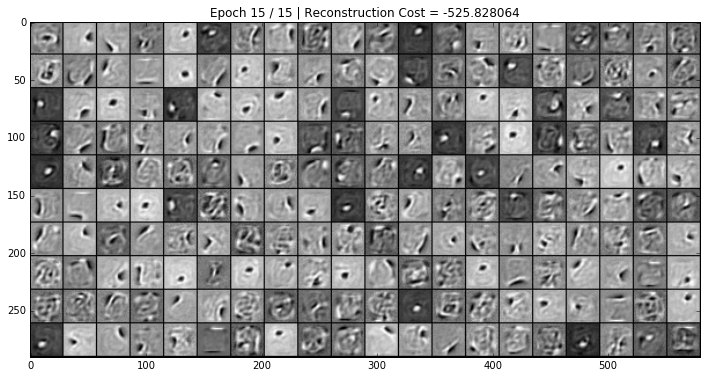

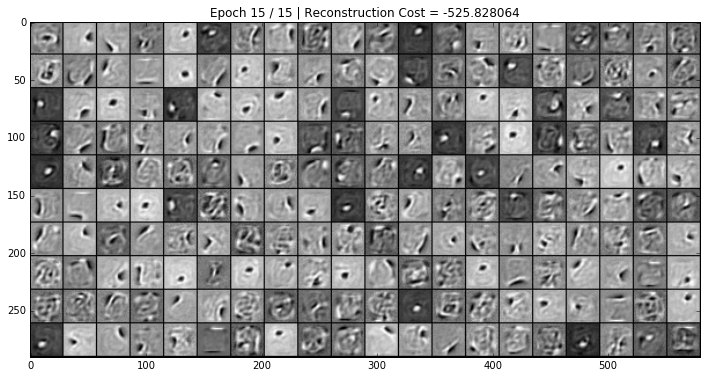

In [9]:
# Create figure first so that we use the same one to draw the filters on during the training
fig = plt.figure(figsize=(12,8))

with tf.Session() as sess:    
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):
        for batch_i in range(n_batches):
            # Get just minibatch amount of data
            idxs_i = batch_idxs[batch_i * batch_size:(batch_i + 1) * batch_size]
            
            # Run the training step
            sess.run(train_op, feed_dict={batch_data: training_data[idxs_i]})
    
        reconstruction_cost = sess.run(xentropy_rec_cost, feed_dict={batch_data: training_data})

        W = rbm.W.eval().transpose()
        filters_grid = create_2d_filters_grid(W, filter_shape=(28,28), grid_size=(10, 20), grid_gap=(1,1))
        
        title = ('Epoch %i / %i | Reconstruction Cost = %f'%
                (epoch+1, training_epochs, reconstruction_cost))
        
        plt.title(title)
        plt.imshow(filters_grid, cmap='gray')
        display.clear_output(wait=True)
        display.display(fig)
        